<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">PROJET DE L'ONCFM - Identification des Faux Billets</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Application des Modèles Entraînés</h2>
</div>

# OBJECTIF DE CE NOTEBOOK

Objectif principal : Utiliser un modèle préalablement entraîné pour prédire la nature des billets (vrai ou faux) à partir de leurs caractéristiques.

Ce notebook se concentrera sur les étapes suivantes :

- **Importation des bibliothèques** : Charger les bibliothèques nécessaires pour la manipulation et la visualisation des données.
- **Chargement du modèle** : Charger le modèle choisi pour effectuer les prédictions.
- **Chargement et préparation des données** : Lire et préparer les données des billets pour les prédictions.
- **Prédiction avec le modèle** : Utiliser un modèle pour prédire la nature des billets.
- **Analyse des résultats** : Afficher les résultats des prédictions et la distribution des billets vrais et faux.


In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import load
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import warnings

# Désactiver les avertissements
warnings.filterwarnings('ignore')

# Charger les modèles
logistic_model = load(r"D:\Mes doc\Formation openclassroom\Projet 12\modèles\logistic_regression_model.joblib")
random_forest_model = load(r"D:\Mes doc\Formation openclassroom\Projet 12\modèles\random_forest_model.joblib")
gradient_boosting_model = load(r"D:\Mes doc\Formation openclassroom\Projet 12\modèles\gradient_boosting_model.joblib")
knn_model = load(r"D:\Mes doc\Formation openclassroom\Projet 12\modèles\knn_model.joblib")
print("Modèles chargés avec succès.")

Modèles chargés avec succès.


# Chargement et Préparation des Données

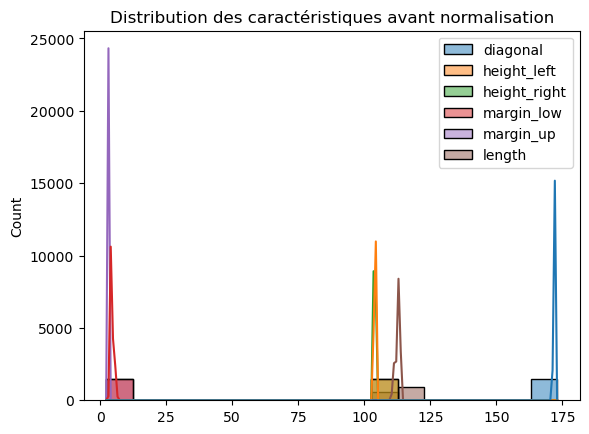

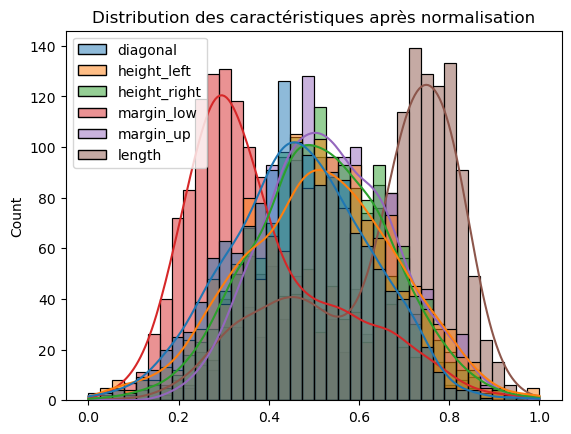

Normalisation des données terminée.


In [2]:
# Charger les données
csv_path = r"D:\Mes doc\Formation openclassroom\Projet 12\fichier test\billets.csv"
user_data = pd.read_csv(csv_path, sep=';'  )

# Vérifier la présence de la colonne 'id'
if 'id' not in user_data.columns:
    raise ValueError("Le fichier d'entrée ne contient pas de colonne 'id'. Veuillez vérifier les données.")

# Supprimer la colonne 'is_genuine' si elle existe
user_data.drop(columns=['is_genuine'], inplace=True, errors='ignore')

# Visualiser les distributions avant normalisation
sns.histplot(data=user_data.drop(columns=['id']), kde=True)
plt.title('Distribution des caractéristiques avant normalisation')
plt.show()

# Normaliser les données en conservant la colonne 'id'
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(user_data.drop(columns=['id']))
features_scaled_df = pd.DataFrame(features_scaled, columns=user_data.columns.drop('id'))
features_scaled_df['id'] = user_data['id']

# Visualiser les distributions après normalisation
sns.histplot(data=features_scaled_df.drop(columns=['id']), kde=True)
plt.title('Distribution des caractéristiques après normalisation')
plt.show()
print("Normalisation des données terminée.")

<div style="background-color: RGB(0,150,250);"> <h2 style="margin: auto; padding: 20px; color:#fff;">Imputation des Valeurs Manquantes et Préparation des Données pour la Prédiction</h2> </div>

Nous utilisons une régression linéaire pour imputer les valeurs manquantes dans les caractéristiques des billets. Pour chaque colonne avec des valeurs manquantes, nous entraînons un modèle de régression linéaire en utilisant les autres colonnes comme caractéristiques. Les valeurs manquantes sont ensuite prédites et imputées.

In [3]:
# Appliquer la régression linéaire pour imputer les données manquantes
linear_model = LinearRegression()
missing_columns = features_scaled_df.columns[features_scaled_df.isnull().any()]
print(f"Colonnes avec des données manquantes : {missing_columns.tolist()}")

for column in missing_columns:
    non_missing_data = features_scaled_df[features_scaled_df[column].notnull()]
    X_train = non_missing_data.drop(columns=[column, 'id'])
    y_train = non_missing_data[column]
    linear_model.fit(X_train, y_train)
    X_missing = features_scaled_df[features_scaled_df[column].isnull()].drop(columns=[column, 'id'])
    features_scaled_df.loc[features_scaled_df[column].isnull(), column] = linear_model.predict(X_missing)

print("Imputation des données manquantes terminée.")
print(features_scaled_df.isnull().sum())

Colonnes avec des données manquantes : ['margin_low']
Imputation des données manquantes terminée.
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
id              0
dtype: int64


<div style="background-color: RGB(0,150,250);"> <h2 style="margin: auto; padding: 20px; color:#fff;">Prédiction avec le Modèle random_forest</h2> </div>


Nous utilisons le modèle de random_forest chargé pour effectuer des prédictions sur les données préparées. Les prédictions déterminent si les billets sont vrais ou faux. Nous mettons ensuite à jour la colonne `is_genuine` avec les résultats des prédictions dans le DataFrame original.


In [4]:
# Préparer les données pour la prédiction
features_for_prediction = features_scaled_df.drop(columns=['id'])

# Prédictions avec le modèle random_forest
probabilities = random_forest_model.predict_proba(features_for_prediction)[:, 1]

# Ajouter les prédictions et les scores de probabilité au DataFrame original
user_data['is_genuine'] = (probabilities > 0.5).astype(int)  # Trancher à 0.5 pour les classes
user_data['proba_score'] = probabilities

<div style="background-color: RGB(0,150,250);"> <h2 style="margin: auto; padding: 20px; color:#fff;">Analyse des Résultats des Prédictions</h2> </div>

Nous analysons les résultats des prédictions en visualisant la distribution des billets vrais et faux après prédiction à l'aide d'un graphique à barres.

Ensuite, nous créons un tableau récapitulatif qui montre le nombre de billets vrais et faux pour mieux comprendre la répartition des résultats de nos prédictions.


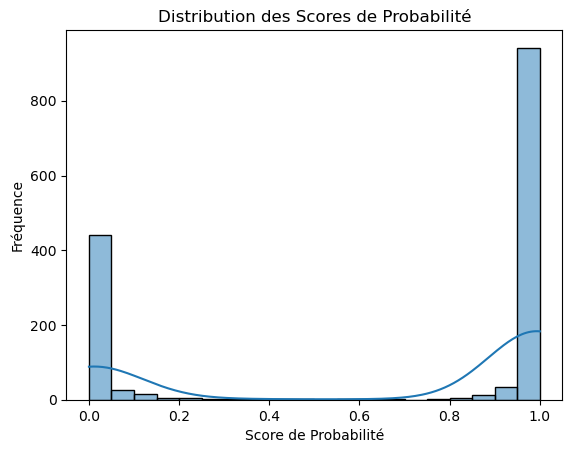

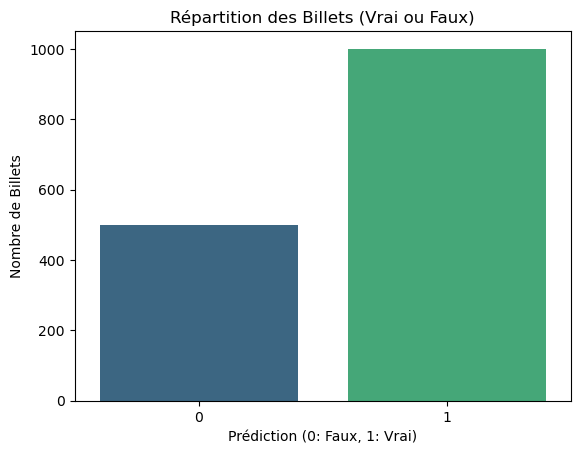


Tableau récapitulatif des billets vrais et faux :
is_genuine  Nombre de Billets
      Vrai               1001
      Faux                499


In [5]:
# Visualisation des probabilités
sns.histplot(user_data['proba_score'], kde=True, bins=20)
plt.title('Distribution des Scores de Probabilité')
plt.xlabel('Score de Probabilité')
plt.ylabel('Fréquence')
plt.show()

# Distribution des billets authentiques et faux après prédiction
sns.countplot(data=user_data, x='is_genuine', palette='viridis')
plt.title('Répartition des Billets (Vrai ou Faux)')
plt.xlabel('Prédiction (0: Faux, 1: Vrai)')
plt.ylabel('Nombre de Billets')
plt.show()

# Tableau récapitulatif des billets vrais et faux
billets_vrais_faux = user_data['is_genuine'].value_counts().reset_index()
billets_vrais_faux.columns = ['is_genuine', 'Nombre de Billets']
billets_vrais_faux['is_genuine'] = billets_vrais_faux['is_genuine'].replace({0: 'Faux', 1: 'Vrai'})
print("\nTableau récapitulatif des billets vrais et faux :")
print(billets_vrais_faux.to_string(index=False))

In [6]:
display(user_data)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine,proba_score
0,171.81,104.86,104.95,4.52,2.89,112.83,1,1,0.90
1,171.46,103.36,103.66,3.77,2.99,113.09,2,1,1.00
2,172.69,104.48,103.50,4.40,2.94,113.16,3,1,1.00
3,171.36,103.91,103.94,3.62,3.01,113.51,4,1,1.00
4,171.73,104.28,103.46,4.04,3.48,112.54,5,1,0.90
...,...,...,...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28,1496,0,0.03
1496,172.19,104.63,104.44,5.27,3.37,110.97,1497,0,0.00
1497,171.80,104.01,104.12,5.51,3.36,111.95,1498,0,0.00
1498,172.06,104.28,104.06,5.17,3.46,112.25,1499,0,0.00


In [7]:
# Sauvegarder les résultats finaux
output_file_predictions = r"D:\Mes doc\Formation openclassroom\Projet 12\fichier test\billets_traité.csv"
user_data.to_csv(output_file_predictions, index=False)
print(f"DataFrame complet avec prédictions sauvegardé sous {output_file_predictions}")

DataFrame complet avec prédictions sauvegardé sous D:\Mes doc\Formation openclassroom\Projet 12\fichier test\billets_traité.csv
